# Pixel-level

By Cascade Tuholske, Sep 2020 <br>
Notebook to generate pixel agreement, coeffiecent of variation of popgrid data, and distributions of pixels. <br>

**Always check file order to drop gpwv4**

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio 
import xarray as xr
import geopandas as gpd
import glob
import rioxarray as rio
from scipy.stats import variation 
import rasterio.mask
import matplotlib.pyplot as plt

In [2]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'

## Pixel Aggreement

In [ ]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'

In [ ]:
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country)
for rst in rst_fns: print(rst) # check them
del rst_fns[0] # drop GPv4
rst_fns

In [ ]:
# Get all arrays
arrs = []

for rst in rst_fns:
    arr = rasterio.open(rst).read(1)
    arrs.append(arr)

In [ ]:
# find areas of agreement
zeros = []
for arr in arrs:
    zero = arr > -999
    zero = zero.astype(int)
    zeros.append(zero)

agg = sum(zeros)

In [ ]:
agg32 = agg.astype('int32')

In [ ]:
# get meta data & write raster 
out_meta = rasterio.open(rst_fns[0]).meta

In [ ]:
fn_out = DATA_PATH+'interim/agg'+country
with rasterio.open(fn_out, "w", **out_meta) as dest:
    dest.write(agg32, 1)

## Coef Var

In [2]:
def open_rst(rst_fn):
    "function opens a raster and makes it into a xarray object"
    
    rst = xr.DataArray(rasterio.open(rst_fn).read(1), dims = ['y', 'x']) # y and x are our 2-d labels
    
    return rst

In [3]:
def rst_coefvar(rst_fns, fn_out):
    """ Calc coef of var on stacked arrays and writes it out as a raster, returns the arr
    fst_fns = list of rasters 
    fn_out = file name and path to write out coef var raster
    """
    
    arr_list = [] # empty list
    
    # open and stack arrays
    for rst_fn in rst_fns:
        
      
        rst_arr = rasterio.open(rst_fn).read(1)
        arr_list.append(rst_arr)
    
    arr3d = np.dstack([arr_list])
        
    # mask zeros
    arr3d[arr3d == -999] = 'nan'
        
    # calculate variance across rasters & get data
    var = variation(arr3d, axis=0, nan_policy = 'propagate')
    arr_out = var.data
    
    # get meta data & write raster 
    out_meta = rasterio.open(rst_fns[0]).meta
    out_meta.update({'dtype' : 'float64'})
    
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(arr_out, 1)
        
    return var

In [28]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'
title = 'Ecuador'

In [39]:
# coefvar all tif files
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country)
for rst in rst_fns: print(rst) # check them
print('\n DID YOU DROP GPWv4???? <<<<----------------------------')

/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_Ecuador.tif

 DID YOU DROP GPWv4???? <<<<----------------------------


In [40]:
del rst_fns[0] # drop GPv4
print('\n')
for rst in rst_fns: print(rst) # check them
print('\n DID YOU DROP GPWv4???? <<<<----------------------------')



/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_Ecuador.tif
/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_Ecuador.tif

 DID YOU DROP GPWv4???? <<<<----------------------------


In [32]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_Ecuador.tif'

In [33]:
# Variance Rst
fn_out = DATA_PATH+'interim/all_coefvar'+country
varall = rst_coefvar(rst_fns, fn_out)
fn_out = DATA_PATH+'FIGS/MS/Fig1_'+title+'.png'

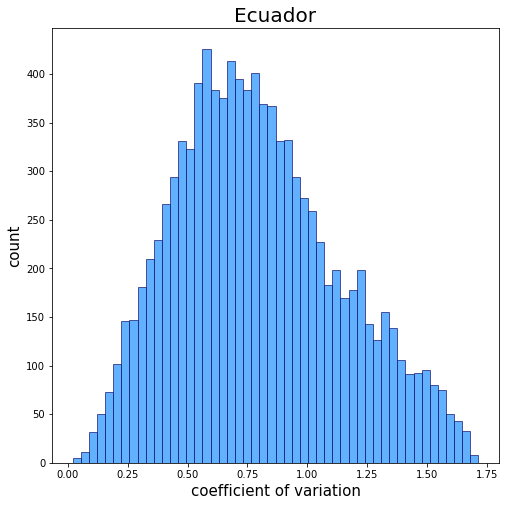

In [34]:
# Plot
fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
#fig.subplots_adjust(wspace=ws)
axs.hist(varall.flatten(), density = False, bins = 50, ec = 'midnightblue', color = 'dodgerblue', alpha = 0.7);
axs.set_title(title, fontsize = 20)
axs.set_xlabel('coefficient of variation', fontsize = 15)
axs.set_ylabel('count', fontsize = 15)

plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

## Distribution of Pixels

In [122]:
fn_out = DATA_PATH+'FIGS/MS/Fig2.png'

In [123]:
def flat(rst_fn):
    "helper to flatten 2d array for histogramss"
    arr = rasterio.open(rst_fn).read(1)
    flat = arr.flatten()
    
    # revalue na -999
    flat = np.where(flat==-999, 0, flat) 
    
    return flat

In [124]:
def get_rsts(country_list):
    "get the rasters to plot by country, drops GPWv4"
    
    rsts_out = [] # out list
    
    for country in country_list:
        
        rst_fns = sorted(glob.glob(DATA_PATH+'interim/*all'+country)) # get rst nms
        
        for i, rst in enumerate(rst_fns): # drop gwpv4
            
            nm = rst.split('interim/')[1].split('_all')[0]      
            if nm == 'GPWv4':
                del rst_fns[i]
        
        rsts_out.append(rst_fns) # append list
        
    return rsts_out

In [125]:
countries = ['_Nepal.tif','_M-M-Z.tif','_Ecuador.tif',]

In [126]:
all_rsts = get_rsts(countries)

In [127]:
# Always update 'GPWv4-15'
names = ['WPE-16', 'GHS-15', 'LS-15', 'WP-16',]

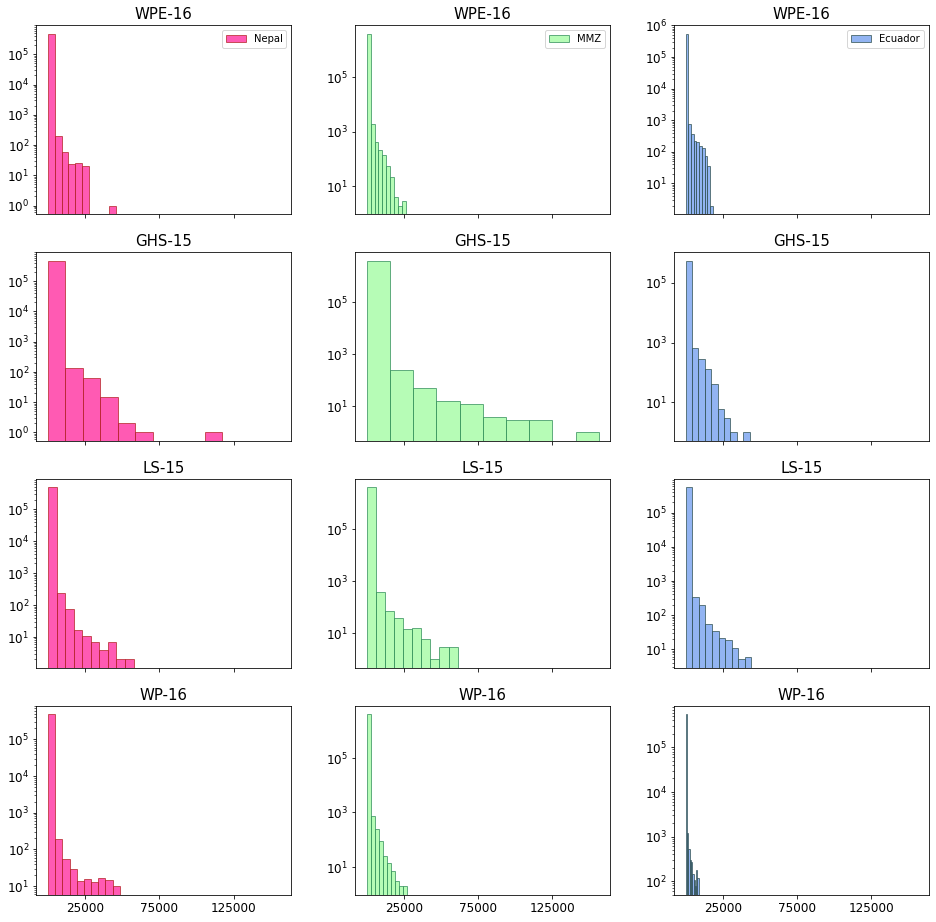

In [128]:
#### Make Figure & Save it

#rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(4, 3, figsize = (16, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

xticks = [25000,75000,125000]

# Nepal
for i, rst_fn in enumerate(zip(all_rsts[0], names)):
    data = flat(rst_fn[0])
    axs[i][0].hist(data, log = True, color = 'deeppink', alpha = 0.7, lw = 1, ec = 'firebrick');#, bins = 10);
    axs[i][0].set_title(rst_fn[1], fontsize = 15)
    axs[i][0].set_xticks(xticks)
    axs[i][0].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][0].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][0].legend(['Nepal']);

# MMZ
for i, rst_fn in enumerate(zip(all_rsts[1], names)):
    data = flat(rst_fn[0])
    axs[i][1].hist(data, log = True, color = 'palegreen', alpha = 0.7, lw = 1, ec = 'seagreen');#, bins = 10);
    axs[i][1].set_title(rst_fn[1], fontsize = 15)
    axs[i][1].set_xticks(xticks)
    axs[i][1].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][1].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][1].legend(['MMZ']);

# Ecuador
for i, rst_fn in enumerate(zip(all_rsts[2], names)):
    data = flat(rst_fn[0])
    axs[i][2].hist(data, log = True, color = 'cornflowerblue', alpha = 0.7, lw = 1, ec = 'darkslategray', bins = 10);
    axs[i][2].set_title(rst_fn[1], fontsize = 15)
    axs[i][2].set_xticks(xticks)
    axs[i][2].tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs[i][2].tick_params(axis = 'both', which = 'minor', labelsize = 12)
axs[0][2].legend(['Ecuador']);

# Save it
plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

In [ ]:
#### Make Figure & Save it
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_Nepal.tif')
rst_fns

#rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)


data = flat(rst_fns[0])
axs.hist(data, log = True, color = 'green', lw = 5, alpha = 0.5, ec = 'green', histtype=u'step');
data = flat(rst_fns[1])
axs.hist(data, log = True, color = 'red', lw = 5, alpha = 0.5, ec = 'red', histtype=u'step');
data = flat(rst_fns[2])
axs.hist(data, log = True, color = 'blue', lw = 5, alpha = 0.5, ec = 'blue', histtype=u'step');
data = flat(rst_fns[3])
axs.hist(data, log = True, color = 'orange', lw = 5, alpha = 0.5, ec = 'orange', histtype=u'step');

## What are the stats?

In [ ]:
# What are the maxium values:
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country+.'tif')

for rst in rst_fns:
    data = (rasterio.open(rst).read(1)).flatten().max()
    print('Max value for', rst.split('interim/')[1], data)


In [ ]:
# What are the maxium values:
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*rural'+country+.'tif')

for rst in rst_fns:
    data = (rasterio.open(rst).read(1)).flatten().max()
    print('Max value for', rst.split('interim/')[1], data)

In [ ]:
# What are the maxium values:
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*urban'+country+.'tif')

for rst in rst_fns:
    data = (rasterio.open(rst).read(1)).flatten().max()
    print('Max value for', rst.split('interim/')[1], data)